<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/computationalImaging/blob/master/rays/Chini_Tang_OPTI556_Problem4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chini Tang
# OPTI556 HW3 Problem 3, 4

# Problem 4

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from scipy import signal
from scipy import integrate
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams.update({'font.size': 22})
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
import cv2
from keras.datasets import mnist

In [ ]:
l= 10
delta=1
N=28
M=128
code=np.random.randint(0,2,M)
def t(x):
  t=code[np.int(np.floor((x+M/2)/delta))]
  return t
vt=np.vectorize(t)
def p(j):
  xj, yj=delta*divmod(j,N)
  xj=xj-N*delta/2
  yj=yj+l
  return xj, yj
def g(j,x):
  g=t((x+(l/p(j)[1])*p(j)[0])/(1+(l/p(j)[1])))
  return g
def h(i,j):
  h=integrate.quad(lambda x: g(j,x), (i-M/2)*delta-delta/2,(i-M/2)*delta +delta/2)[0]
  return h
H=np.zeros((M,N**2))
for j in range(N**2):
  for i in range(M):
    H[i,j]=h(i,j)

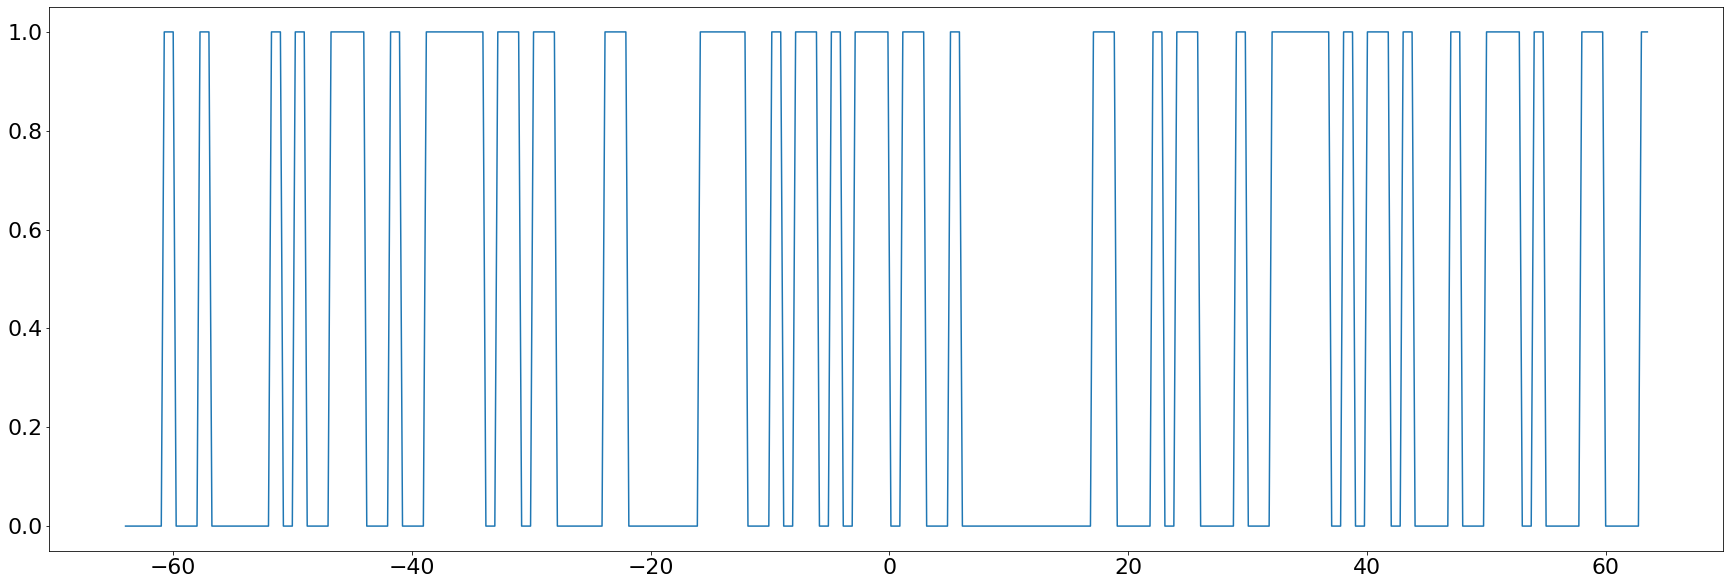

In [ ]:
xspace=np.linspace(-M*delta/2,(M-1)*delta/2,512)
plt.plot(xspace,vt(xspace))

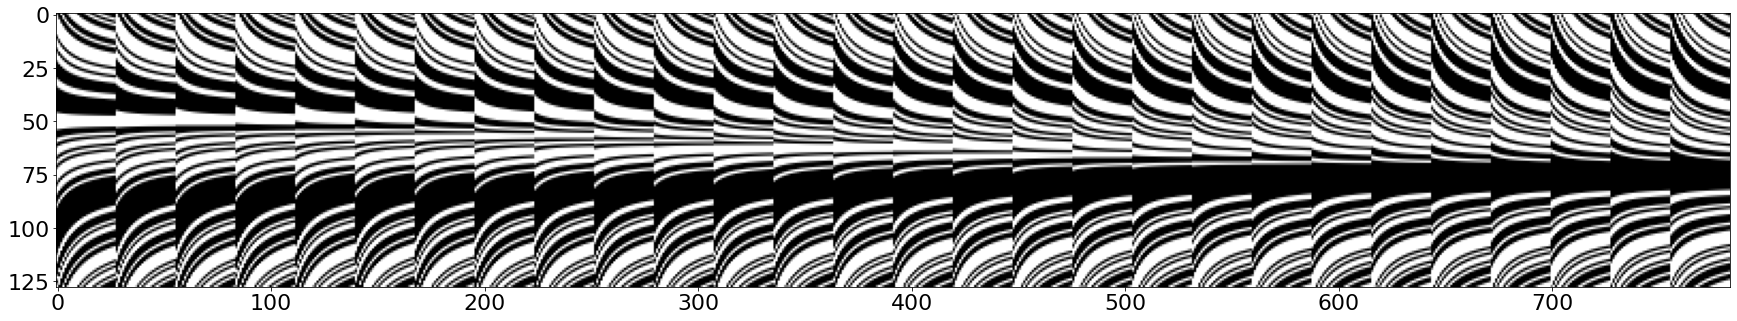

In [ ]:
plt.imshow(H)

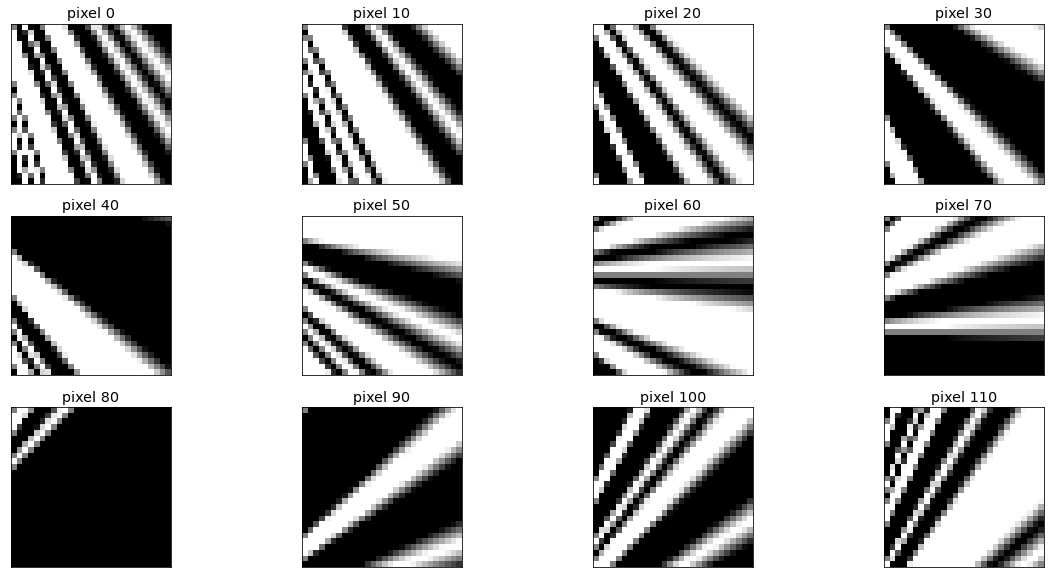

In [ ]:
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 12})
for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(np.reshape(H[10*i,:],(N,N)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('pixel '+np.str(10*i))

In [ ]:
u, lam, vh = np.linalg.svd(H)
ph=np.linalg.pinv(H)

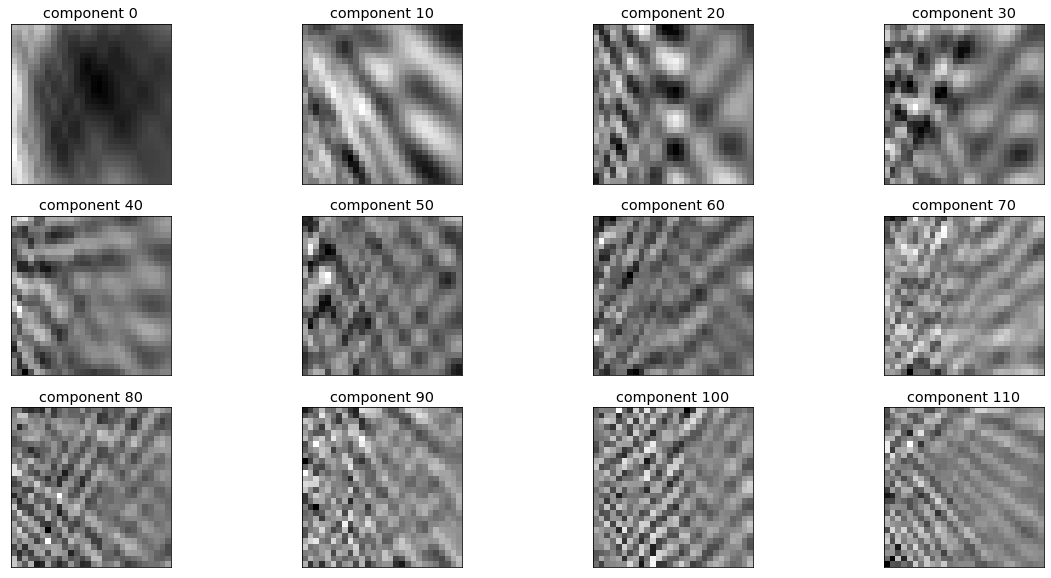

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(np.reshape(vh[10*i,:],(N,N)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('component '+np.str(10*i))

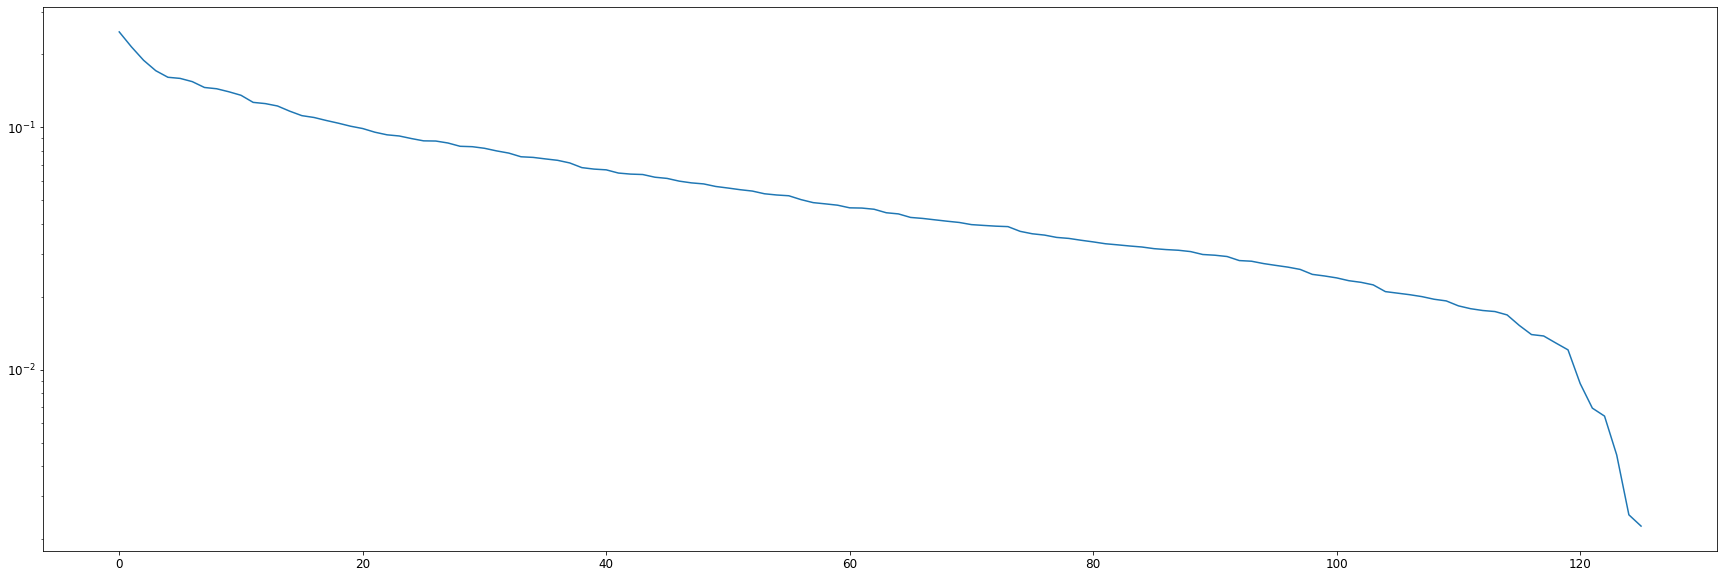

In [ ]:
plt.semilogy(lam[1:127]/lam[0])

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0

Create my rotation matrix. Explanation as follows:

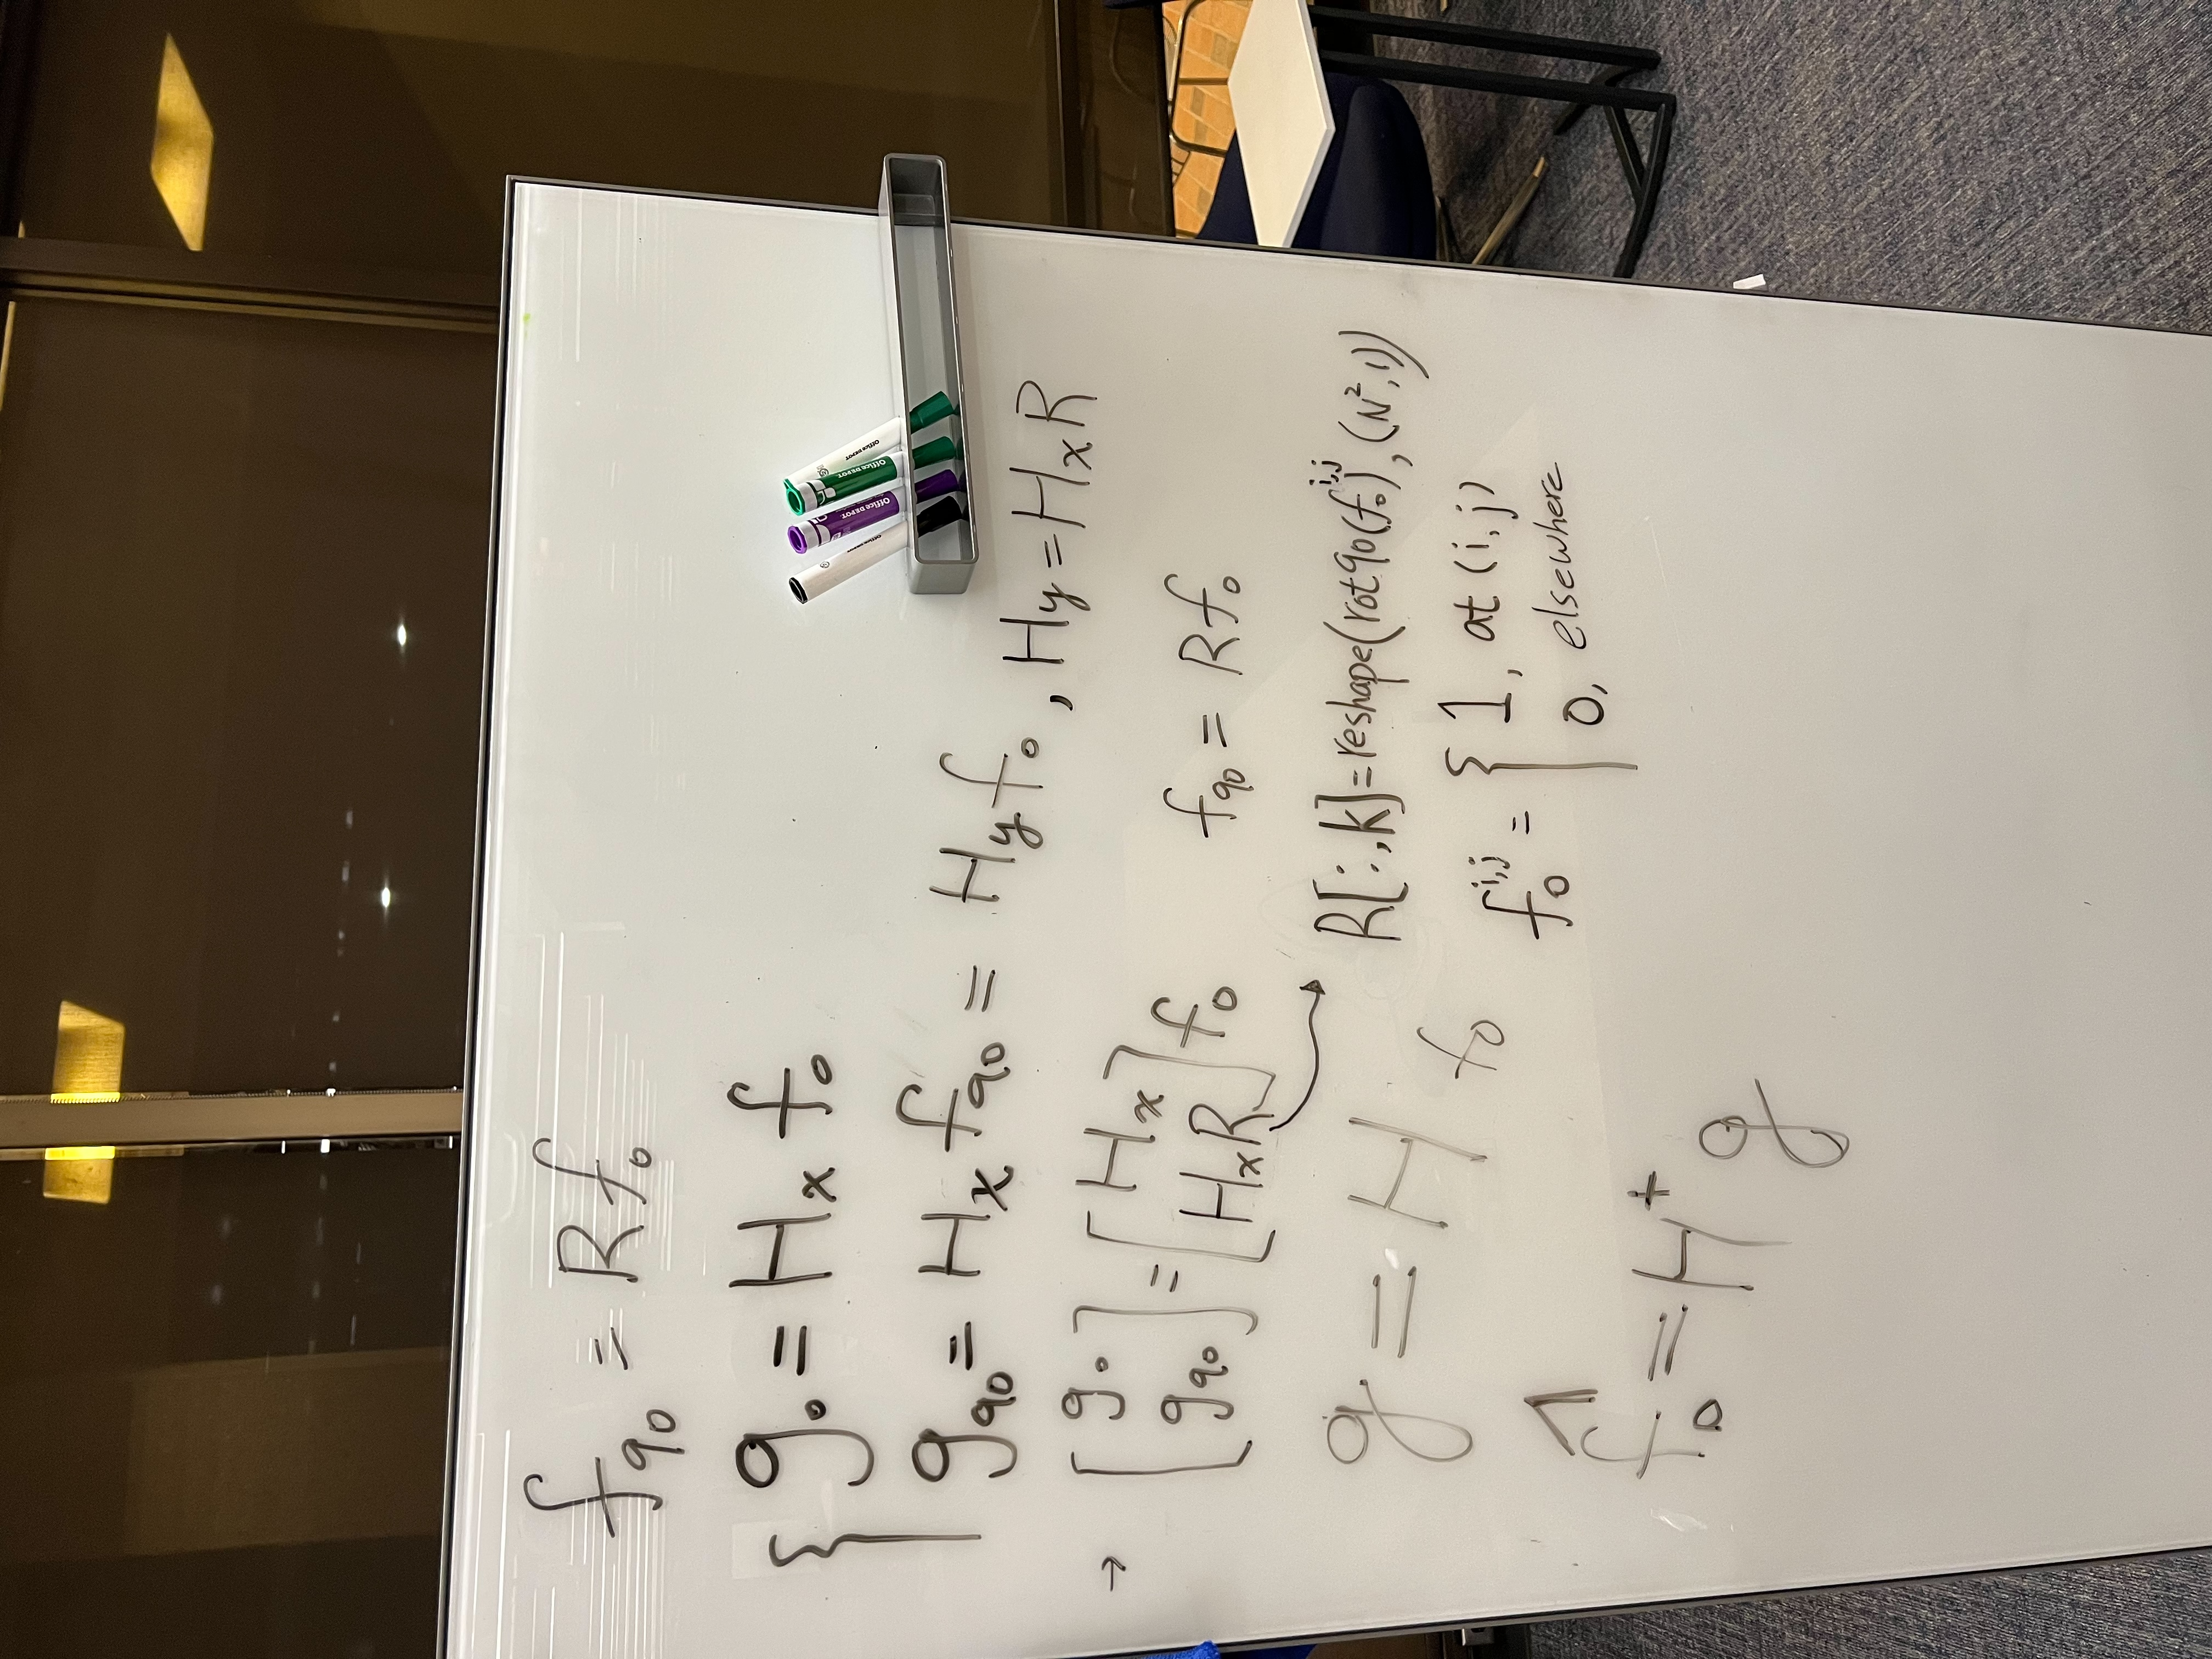

In [ ]:
rotational_matrix = np.zeros((N**2, N**2))
f_impulse = np.zeros((N,N))
k = 0
for i in range(N):
  for j in range(N):
    f_impulse[i,j] = 1
    rotational_matrix[:,k] = np.reshape(np.rot90(f_impulse),(N**2,1))[:,0]
    f_impulse[i,j] = 0
    k += 1
rotational_matrix = np.array(rotational_matrix).astype(int)

test my rotation matrix

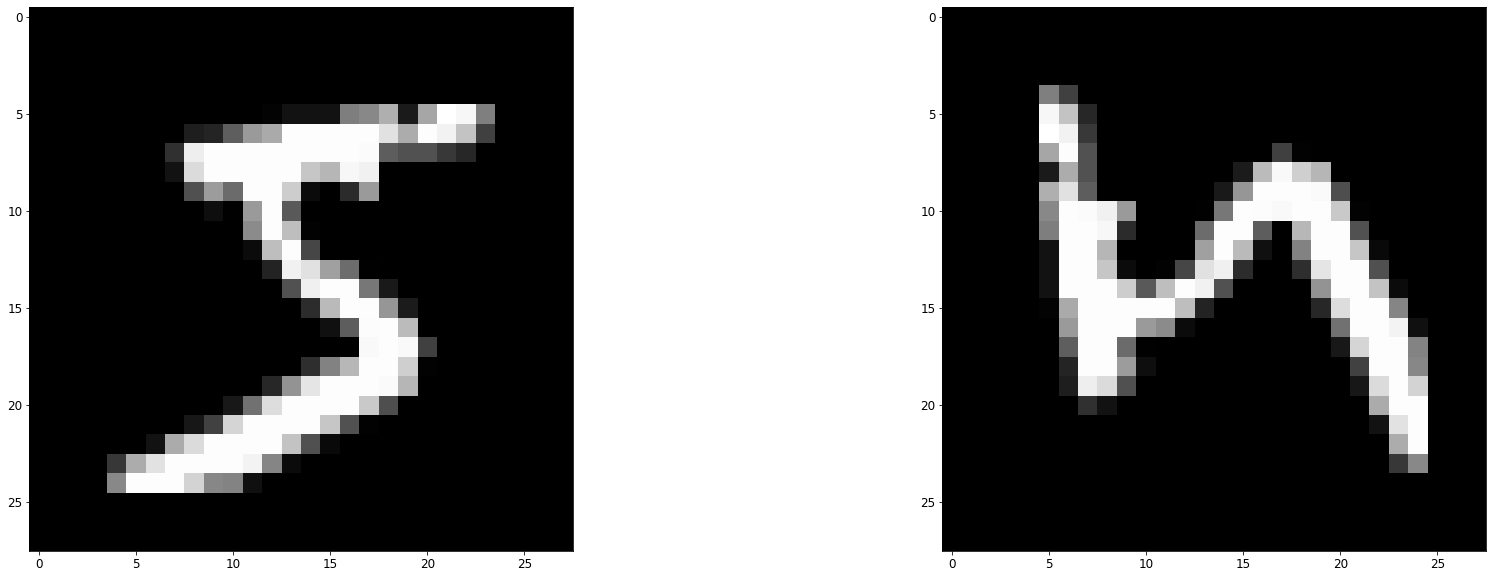

In [ ]:
temp = np.matmul(rotational_matrix,x_train[0,:,:].reshape(-1))
temp = np.reshape(temp, (N,N))
plt.subplot(1,2,1)
plt.imshow(x_train[0,:,:])
plt.subplot(1,2,2)
plt.imshow(temp)

Hy = H*R and combine H and Hy to form a larger H, called modified H (H_all)

In [ ]:
Hy = np.matmul(H,rotational_matrix)
H_all = np.concatenate((H,Hy),axis=0)
ph_all = np.linalg.pinv(H_all)

prepare for training dataset with original H and modified H (H_all)

In [ ]:
g_test_ori=np.zeros(np.shape(x_test))
g_train_ori=np.zeros(np.shape(x_train))

g_test_mod=np.zeros(np.shape(x_test))
g_train_mod=np.zeros(np.shape(x_train))

for pop in range(np.shape(x_test)[0]):
  g_test_ori[pop,:,:] = np.reshape(np.matmul(ph,np.matmul(H,np.reshape(x_test[pop],N**2))),(N,N))
  g_test_ori[pop,:,:] = g_test_ori[pop,:,:]/np.max(g_test_ori[pop,:,:])

  g_test_mod[pop,:,:] = np.reshape(np.matmul(ph_all,np.matmul(H_all,np.reshape(x_test[pop],N**2))),(N,N))
  g_test_mod[pop,:,:] = g_test_mod[pop,:,:]/np.max(g_test_mod[pop,:,:])

for pop in range(np.shape(x_train)[0]):
  g_train_ori[pop,:,:] = np.reshape(np.matmul(ph,np.matmul(H,np.reshape(x_train[pop],N**2))),(N,N))
  g_train_ori[pop,:,:] = g_train_ori[pop,:,:]/np.max(g_train_ori[pop,:,:])

  g_train_mod[pop,:,:] = np.reshape(np.matmul(ph_all,np.matmul(H_all,np.reshape(x_train[pop],N**2))),(N,N))
  g_train_mod[pop,:,:] = g_train_mod[pop,:,:]/np.max(g_train_mod[pop,:,:])

x_train = np.reshape(x_train, (len(x_train), N, N, 1))
x_test = np.reshape(x_test, (len(x_test), N, N, 1))
g_train_ori = np.reshape(g_train_ori, (len(g_train), N, N, 1))
g_test_ori = np.reshape(g_test_ori, (len(g_test), N, N, 1))
g_train_mod = np.reshape(g_train_mod, (len(g_train), N, N, 1))
g_test_mod = np.reshape(g_test_mod, (len(g_test), N, N, 1))


The training dataset looks better if I applied modified H and pinv(H)

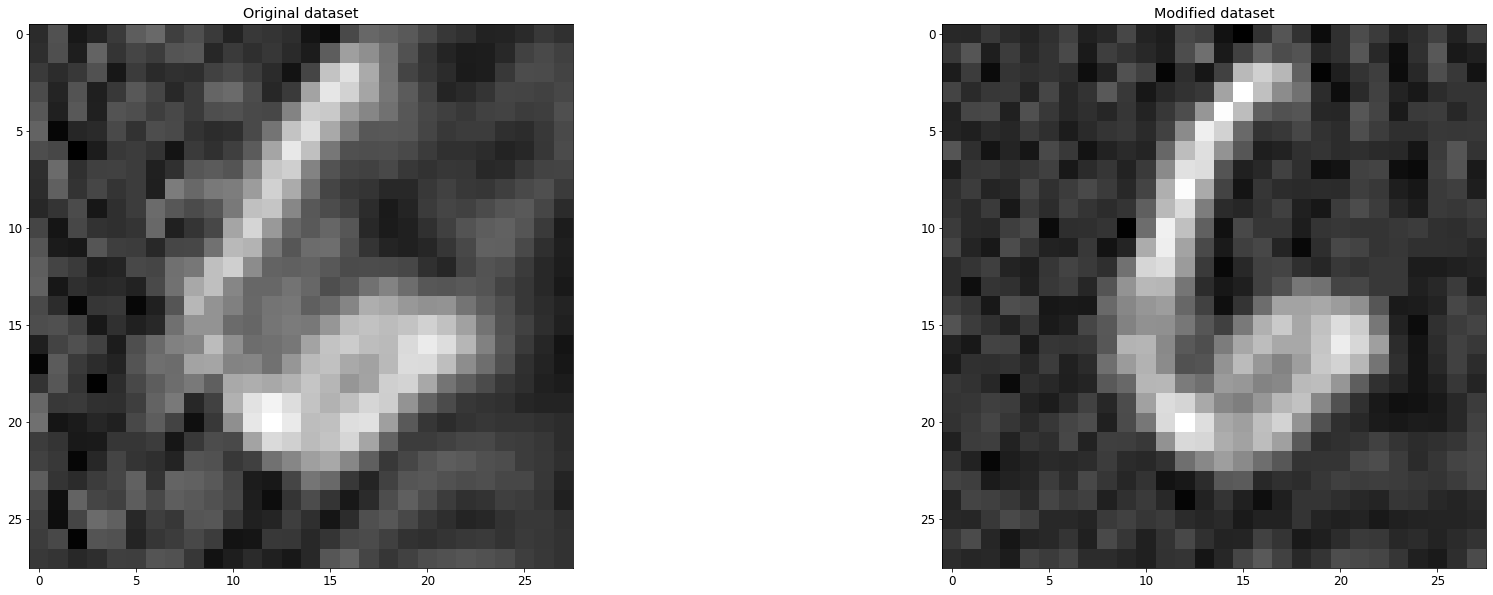

In [ ]:
plt.subplot(1,2,1)
plt.title("Original dataset")
plt.imshow(g_train_ori[32,:,:,0])
plt.subplot(1,2,2)
plt.title("Modified dataset")
plt.imshow(g_train_mod[32,:,:,0])

In [ ]:
inputs=keras.Input(shape=(N, N, 1))

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="relu", padding="same")(inputs)
x = layers.Conv2D(32, (4, 4), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(1, (3, 3), activation="linear", padding="same")(x)

autoencoder_5 = keras.Model(inputs, x)
autoencoder_5.compile(optimizer='adam', loss='mean_squared_error')

autoencoder_6 = keras.Model(inputs, x)
autoencoder_6.compile(optimizer='adam', loss='mean_squared_error')
autoencoder_6.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        16416     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 28, 28, 16)        4624

training the network with original training dataset

In [ ]:
autoencoder_5.fit(
    x=g_train_ori,
    y=x_train,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test_ori, x_test),
)

Epoch 1/30
469/469 [==============================] - 14s 28ms/step - loss: 0.0086 - val_loss: 0.0062
Epoch 2/30
469/469 [==============================] - 13s 28ms/step - loss: 0.0059 - val_loss: 0.0054
Epoch 3/30
469/469 [==============================] - 13s 28ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 4/30
469/469 [==============================] - 13s 28ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 5/30
469/469 [==============================] - 13s 28ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 6/30
469/469 [==============================] - 13s 28ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 7/30
469/469 [==============================] - 13s 28ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 8/30
469/469 [==============================] - 13s 28ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 9/30
469/469 [==============================] - 13s 28ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 10/30
469/469 [==============================] - 13s 28ms/step - loss: 0.004

training the network with modified training dataset

In [ ]:
autoencoder_6.fit(
    x=g_train_mod,
    y=x_train,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test_mod, x_test),
)

Epoch 1/30
469/469 [==============================] - 14s 28ms/step - loss: 0.0124 - val_loss: 0.0036
Epoch 2/30
469/469 [==============================] - 13s 28ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 3/30
469/469 [==============================] - 13s 28ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 4/30
469/469 [==============================] - 13s 28ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 5/30
469/469 [==============================] - 13s 28ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 6/30
469/469 [==============================] - 13s 27ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 7/30
469/469 [==============================] - 13s 28ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 8/30
469/469 [==============================] - 13s 27ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 9/30
469/469 [==============================] - 13s 28ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 10/30
469/469 [==============================] - 13s 28ms/step - loss: 0.002

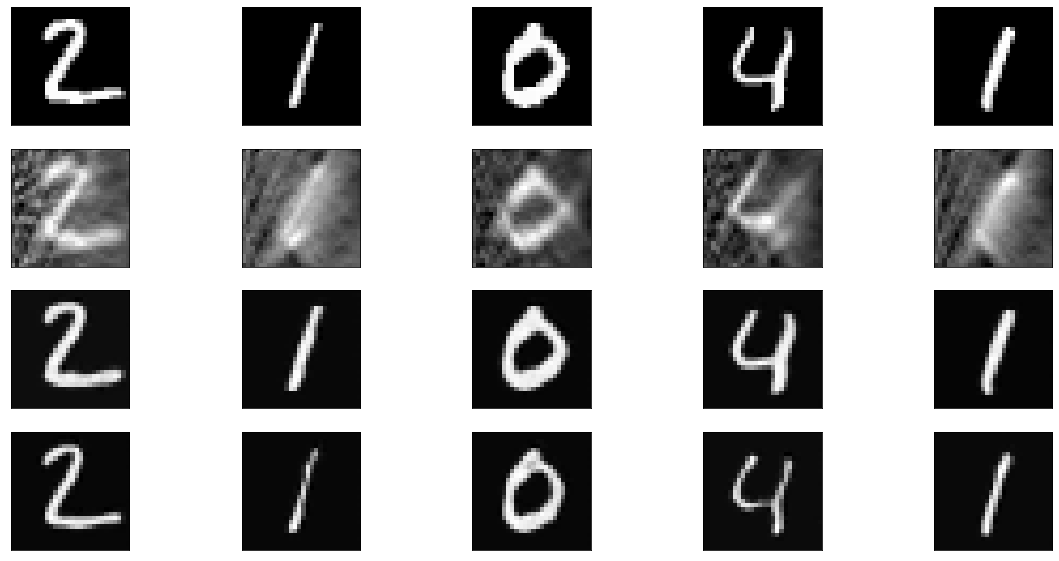

In [ ]:

n = 5
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(4, n, i)
    plt.imshow(x_test[i].reshape(N, N))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(4, n, n+i)
    plt.imshow(g_test_ori[i].reshape(N, N))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(4, n, 2*n+i)
    plt.imshow(autoencoder_5.predict(g_test_ori[i:(i+1),:,:,:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(4, n, 3*n+i)
    plt.imshow(autoencoder_6.predict(g_test_mod[i:(i+1),:,:,:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

The average validation loss using original training dataset is 0.0040.

THe average validation loss using modified training dataset is 0.0016, better than original results.

